In [20]:
from grid_search_tools import GSTools
from ptstrategy_cointegration_kalman import CointKalmanStrategy
from custom_analyzer import Metrics
from pandas_datafeed import PandasData
from pair_selector import *

import backtrader as bt
import backtrader.feeds as btfeeds
import pandas as pd
import warnings
import glob
import os
import uuid
import itertools
import json

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# INPUT PARAMETERS

DIR = "../ib-data/nyse-daily-tech/"

BT_START_DT = '2018-03-19'
TEST_PERIOD = 200

PRE_PAIR_FORMATION = 252 + 252 + 252 + 52 - 60 - 52
PAIR_FORMATION_LEN = 60

# top PCT percentage of the pairs with lowest distance will be backtested
PCT = 0.9

# STRATEGY PARAMETERS
ENTER_THRESHOLD_SIZE = [2]
EXIT_THRESHOLD_SIZE = [0.25, 0.5]
LOSS_LIMIT = [-0.005]
MAX_LOOKBACK = 52
CONSIDER_BORROW_COST = False
CONSIDER_COMMISSION = True

# ADDITIONAL INFO
OTHER_INFO = ""

# Where to save the ouputs
DST_DIR = "../backtest-results/cointegration-kalman/experiment3-y3/"

In [3]:
CONFIG = {
    'DIR': DIR,
    'BT_START_DT': BT_START_DT,
    'TEST_PERIOD': TEST_PERIOD,
    'PAIR_FORMATION_LEN': PAIR_FORMATION_LEN,
    'PCT': PCT,
    'ENTER_THRESHOLD_SIZE': ENTER_THRESHOLD_SIZE,
    'EXIT_THRESHOLD_SIZE': EXIT_THRESHOLD_SIZE,
    'LOSS_LIMIT': LOSS_LIMIT,
    'MAX_LOOKBACK': MAX_LOOKBACK,
    'CONSIDER_BORROW_COST': CONSIDER_BORROW_COST,
    'CONSIDER_COMMISSION': CONSIDER_COMMISSION,
    'DST_DIR': DST_DIR,
    'OTHER_INFO': OTHER_INFO,
}

# create json string
CONFIG_JSON_STR = json.dumps(CONFIG)

# create directory if neccessary
if not os.path.exists(DST_DIR):
    os.makedirs(DST_DIR)
    
# save json string to a file
with open(DST_DIR + 'config.json', 'w') as outfile:
    json.dump(CONFIG_JSON_STR, outfile)

In [21]:
print("---------------------------------------------------------------------")

###################################################################################################################
# Load data
data = GSTools.load_csv_files(DIR)
dt_idx = GSTools.get_trading_dates(data)

print("Initial number of datafeeds: " + str(len(dt_idx)) + ".")

###################################################################################################################
# get position of intended start date of backtest
bt_start_idx = dt_idx.get_loc(BT_START_DT)
size = PRE_PAIR_FORMATION + PAIR_FORMATION_LEN + MAX_LOOKBACK + (len(dt_idx) - bt_start_idx)

print("To fulfill BT_START_DT, PAIR_FORMATION_LEN and MAX_LOOKBACK, size = " + str(size) + ".")

# get datafeeds which fulfill size requirement
data = GSTools.cut_datafeeds(data, size=size)

print("After cutting datafeeds, " + str(len(data.keys())) + " datafeeds remaining.")

###################################################################################################################
# just to be safe, sync the start end dates of the dataframes
data, start_dt, end_dt = GSTools.sync_start_end(data)
dt_idx = GSTools.get_trading_dates(data)

print("Backtest start date: " + str(dt_idx[PRE_PAIR_FORMATION + PAIR_FORMATION_LEN + MAX_LOOKBACK]))
print("Backtest end date: " + str(dt_idx[PRE_PAIR_FORMATION + PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD - 1]))

###################################################################################################################
# get aggregated close prices
close_df = GSTools.get_aggregated(data, col='close')

if close_df.isnull().values.any():
    warnings.warn("There are null values in the aggregated close price df.")
else:
    print("No null values detected in aggregated close price df.")

###################################################################################################################
# total number of stocks remaining
N = len(data.keys())

# number of pairs of interest
K = int(PCT * N * (N-1) / 2)

###################################################################################################################
# pair selection
good_pairs = coint(df=close_df[PRE_PAIR_FORMATION:PRE_PAIR_FORMATION + PAIR_FORMATION_LEN], intercept=True, sig_level=0.005)
good_pairs.sort(key=lambda x: x[2])
good_pairs = good_pairs[0 : K]

print("From " + str(int(N * (N-1) / 2)) + " pairs, " + str(len(good_pairs)) + " pairs passed the cointegration test.")

print("---------------------------------------------------------------------")

---------------------------------------------------------------------
Initial number of datafeeds: 2517.
To fulfill BT_START_DT, PAIR_FORMATION_LEN and MAX_LOOKBACK, size = 1010.
After cutting datafeeds, 116 datafeeds remaining.
Backtest start date: 2018-03-19 00:00:00
Backtest end date: 2019-01-02 00:00:00
No null values detected in aggregated close price df.
From 6670 pairs, 231 pairs passed the cointegration test.
---------------------------------------------------------------------


In [27]:
GSTools.get_aggregated_with_dates(data, col='close').set_index("date").loc["2015-01-02":"2015-01-10"]

,AAN,AER,AL,AMBR,AMN,ANET,ASGN,ATEN,ATHM,ATU,...,UIS,UMC,URI,VEEV,VMW,WIT,WK,WUBA,XRX,ZEN
date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,30.615,38.515,34.380,10.155,19.225,62.655,32.505,4.535,37.755,27.155,...,28.895,2.245,103.585,26.205,82.075,11.345,13.585,41.915,36.2350,24.540
2015-01-05,30.505,38.255,33.475,10.010,18.925,63.835,31.990,4.370,37.040,26.275,...,28.095,2.295,92.245,26.220,81.010,11.205,13.990,42.510,35.4725,24.055
2015-01-06,29.335,38.235,33.505,10.070,18.435,63.790,31.275,4.565,35.905,25.745,...,27.055,2.235,89.375,27.125,78.815,11.035,13.955,40.585,34.9450,24.530
2015-01-07,30.245,38.605,33.445,9.835,18.640,65.110,32.105,4.565,38.890,25.285,...,27.335,2.265,88.735,27.180,78.835,11.165,14.230,40.480,35.3925,24.520
2015-01-08,30.755,39.525,34.180,9.955,18.535,66.070,32.615,5.185,38.505,24.905,...,27.725,2.355,90.475,28.385,79.790,11.335,15.015,41.585,36.3950,24.995
2015-01-09,30.375,39.155,33.205,10.145,18.455,66.395,32.020,5.445,41.435,24.585,...,27.415,2.385,89.310,28.795,78.885,11.215,15.930,40.605,36.1575,25.135


In [59]:
# combinations of parameters
param_combinations = list(itertools.product(ENTER_THRESHOLD_SIZE, EXIT_THRESHOLD_SIZE, LOSS_LIMIT))

# list to store MACRO results
macro_results = []

for i, params in enumerate(param_combinations, 1):
    # set params
    print("Running " + str(i) + "/" + str(len(param_combinations)))
    print("Backtesting all pairs using parameters " + str(params))
    # list to store MICRO results
    results = []

    for pair in good_pairs:
        # get names of both stock
        stk0, stk1, _ = pair

        # get data of both stock
        stk0_df, stk1_df = data[stk0], data[stk1]
        stk0_df_test = stk0_df[PRE_PAIR_FORMATION + PAIR_FORMATION_LEN : PRE_PAIR_FORMATION + PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]
        stk1_df_test = stk1_df[PRE_PAIR_FORMATION + PAIR_FORMATION_LEN : PRE_PAIR_FORMATION + PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]
        
        # Create a cerebro
        cerebro = bt.Cerebro()

        # Create data feeds
        data0 = bt.feeds.PandasData(dataname=stk0_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)
        data1 = bt.feeds.PandasData(dataname=stk1_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)

        # add data feeds to cerebro
        cerebro.adddata(data0)
        cerebro.adddata(data1)

        # Add the strategy
        cerebro.addstrategy(CointKalmanStrategy, 
                            max_lookback=MAX_LOOKBACK,
                            enter_threshold_size=params[0], 
                            exit_threshold_size=params[1], 
                            loss_limit=params[2],
                            consider_borrow_cost=CONSIDER_BORROW_COST,
                            consider_commission=CONSIDER_COMMISSION
                           )

        # Add analyzers
        cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
        cerebro.addanalyzer(Metrics, 
                            lookback=MAX_LOOKBACK, 
                            _name='metrics')

        # Add the commission - only stocks like a for each operation
        cerebro.broker.setcash(1000000)

        # And run it
        strat = cerebro.run()

        # get MICRO metrics
        sharperatio = strat[0].analyzers.mysharpe.get_analysis()['sharperatio']
        returnstd = strat[0].analyzers.metrics.returns_std()
        startcash = cerebro.getbroker().startingcash
        endcash = cerebro.getbroker().getvalue()
        profit = (endcash - startcash) / startcash
        
        results.append((stk0 + "-" + stk1, sharperatio, profit, returnstd))
    
    # convert to dataframe
    results_df = pd.DataFrame(results)
    results_df.columns = ['pair', 'sharpe_ratio', 'overall_return', 'returns_std']
    
    # save as csv
    uuid_str = str(uuid.uuid4())
    path = DST_DIR + str(uuid_str) + ".csv" 
    results_df.to_csv(path_or_buf=path, index=False)
    
    # calculate MACRO attributes
    avg_sharpe_ratio = results_df['sharpe_ratio'].mean()
    median_sharpe_ratio = results_df['sharpe_ratio'].median()
    
    avg_overall_return = results_df['overall_return'].mean()
    median_overall_return = results_df['overall_return'].median()
    overall_return_std = results_df['overall_return'].std()

    
    macro_results.append((params[0], 
                          params[1], 
                          params[2], 
                          avg_sharpe_ratio,
                          median_sharpe_ratio,
                          avg_overall_return,
                          median_overall_return,
                          overall_return_std,
                          uuid_str
                         ))
    
    # nextline
    print("")

macro_results_df = pd.DataFrame(macro_results)
macro_results_df.columns = ['enter_threshold_size', 
                            'exit_threshold_size',
                            'loss_limit', 
                            'avg_sharpe_ratio', 
                            'median_sharpe_ratio',
                            'avg_overall_return', 
                            'median_overall_return',
                            'overall_return_std',
                            'uuid']
macro_results_df.to_csv(DST_DIR + 'summary.csv', index=False)

Running 1/2
Backtesting all pairs using parameters (2, 0.25, -0.005)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Running 2/2
Backtesting all pairs using parameters (2, 0.5, -0.005)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


In [60]:
macro_results_df = pd.read_csv(DST_DIR + 'summary.csv')
macro_results_df

,enter_threshold_size,exit_threshold_size,loss_limit,avg_sharpe_ratio,median_sharpe_ratio,avg_overall_return,median_overall_return,overall_return_std,uuid
0,2,0.25,-0.005,-52.268953,-1.368728,0.004845,0.0,0.080181,01a0d103-897f-4591-bbc2-7c1ec6a6d859
1,2,0.50,-0.005,-52.417195,-1.384263,0.003729,0.0,0.083530,0c7199bb-47d4-4646-a6e0-d86309ceec9f


In [17]:
macro_results_df[macro_results_df['avg_overall_return'] == max(macro_results_df['avg_overall_return'])]

,enter_threshold_size,exit_threshold_size,loss_limit,avg_sharpe_ratio,median_sharpe_ratio,avg_overall_return,median_overall_return,overall_return_std,uuid
2,1.0,0.25,-0.005,NaN,NaN,-0.003228,-0.000822,0.119215,9bd2d539-20d8-4423-926a-52cc8a0386ed


### Test single pair

In [17]:
# set your params
_STK0 = 'ATEN'
_STK1 = 'DQ'
_MAX_LOOKBACK = 252
_ENTER_THRESHOLD_SIZE = 1.25
_EXIT_THRESHOLD_SIZE = 0.5
_LOSS_LIMIT = -0.02

In [18]:
def backtest_single_pair(_stk0, _stk1, _max_lookback, _enter_threshold_size, _exit_threshold_size, _loss_limit):
    # get data of both stock
    stk0_df, stk1_df = data[_stk0], data[_stk1]
    stk0_df_test = stk0_df[PRE_PAIR_FORMATION + PAIR_FORMATION_LEN : PRE_PAIR_FORMATION + PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]
    stk1_df_test = stk1_df[PRE_PAIR_FORMATION + PAIR_FORMATION_LEN : PRE_PAIR_FORMATION + PAIR_FORMATION_LEN + MAX_LOOKBACK + TEST_PERIOD]

    # Create a cerebro
    cerebro = bt.Cerebro()

    # Create data feeds
    data0 = bt.feeds.PandasData(dataname=stk0_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)
    data1 = bt.feeds.PandasData(dataname=stk1_df_test, timeframe=(bt.TimeFrame.Days), datetime=0)

    # add data feeds to cerebro
    cerebro.adddata(data0)
    cerebro.adddata(data1)

    # Add the strategy
    cerebro.addstrategy(CointKalmanStrategy, 
                        max_lookback=_max_lookback,
                        enter_threshold_size=_enter_threshold_size, 
                        exit_threshold_size=_exit_threshold_size, 
                        loss_limit=_loss_limit,
                        print_bar=False,
                        print_msg=True,
                        print_transaction=True,
                       )

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='mysharpe')
    cerebro.addanalyzer(Metrics, 
                        lookback=MAX_LOOKBACK, 
                        _name='metrics')

    # Add the commission - only stocks like a for each operation
    cerebro.broker.setcash(1000000)

    # And run it
    strat = cerebro.run()
    
    return (cerebro, strat)

In [19]:
cerebro, strat = backtest_single_pair(_STK0, _STK1, _MAX_LOOKBACK, _ENTER_THRESHOLD_SIZE, _EXIT_THRESHOLD_SIZE, _LOSS_LIMIT)

2016-02-11T00:00:00, SELL COMPLETE, 5.52
2016-02-11T00:00:00, BUY COMPLETE, 14.09
2016-04-11T00:00:00, BUY COMPLETE, 5.78
2016-04-11T00:00:00, SELL COMPLETE, 19.40
2016-05-02T00:00:00, BUY COMPLETE, 5.92
2016-05-02T00:00:00, SELL COMPLETE, 26.28
2016-05-31T00:00:00, SELL COMPLETE, 6.36
2016-05-31T00:00:00, BUY COMPLETE, 24.68
2016-10-06T00:00:00, BUY COMPLETE, 9.77
2016-10-06T00:00:00, SELL COMPLETE, 21.25
2016-10-07T00:00:00, SELL COMPLETE, 9.68
2016-10-07T00:00:00, BUY COMPLETE, 22.50
2016-10-31T00:00:00, BUY COMPLETE, 7.83
2016-10-31T00:00:00, SELL COMPLETE, 23.63
Starting Value: 1000000.00
Ending   Value: 1470430.29


/home/u24027/.local/lib/python3.6/site-packages/backtrader/plot/__init__.py:30: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/glob/intel-python/versions/2018u2/intelpython3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


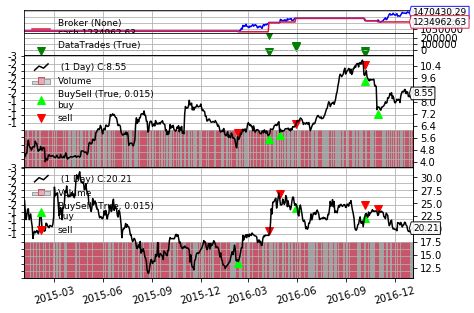

[[<matplotlib.figure.Figure at 0x14cb808297f0>]]

In [20]:
cerebro.plot()

In [21]:
sharperatio = strat[0].analyzers.mysharpe.get_analysis()['sharperatio']
startcash = cerebro.getbroker().startingcash
endcash = cerebro.getbroker().getvalue()
profit = (endcash - startcash) / startcash

print(sharperatio)
print(profit)

0.6650706286988908
0.47043029499999944


In [22]:
n_trades = strat[0].analyzers.metrics.n_trades
n_resolved_trades = strat[0].analyzers.metrics.n_resolved_trades
n_unresolved_trades = strat[0].analyzers.metrics.n_unresolved_trades
avg_holding_period = strat[0].analyzers.metrics.avg_holding_period
len_unresolved_trade= strat[0].analyzers.metrics.len_unresolved_trade

returns = strat[0].analyzers.metrics.returns
pv = strat[0].analyzers.metrics.pv

print(n_trades, n_resolved_trades, n_unresolved_trades, avg_holding_period, len_unresolved_trade)

4 3 1 20.333333333333332 47


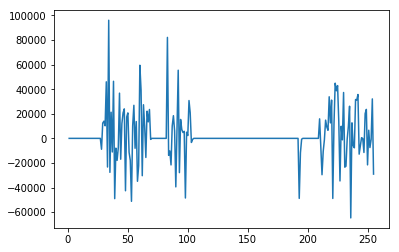

In [23]:
plt.plot(returns)
plt.show()

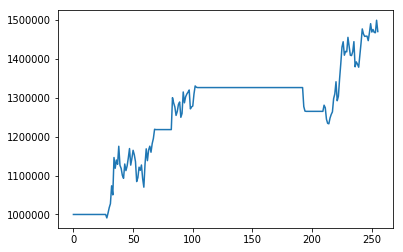

In [24]:
plt.plot(pv)
plt.show()